# Introduction to DSP with PYNQ
# 02: DSP & PYNQ

> In the previous notebook, we used SciPy to analyse an audio recording of 2 birds and used filtering to isolate one of them. In this notebook the same techniques will be used but, this time, we'll be moving the software FFT and FIR functions over to FPGA hardware and controlling them using PYNQ as if they were software!

## Reusing Code

As this is a whole, new notebook we will need to: load in our audio file again, create a way to get our data into the pandas format for Plotly, and set up our plotting template. To keep things simple we can just reuse code from the previous lab rather than writing it all again.

In [1]:
from scipy.io import wavfile
import numpy as np

fs, aud_in = wavfile.read("assets/birds.wav")

import plotly.express as px
import pandas as pd

# Derive a custom plotting template from `plotly_dark`
import plotly.io as pio
new_template = pio.templates['plotly_white']
new_template.update(dict(layout = dict(
        width         = 800,
        autosize      = False,
        legend        = dict(x=1.1),
        paper_bgcolor = 'rgb(0,0,0,0)',
        plot_bgcolor  = 'rgb(0,0,0,0)',
)))

# Register new template as the default
pio.templates['light_plot'] = new_template
pio.templates.default = 'light_plot'

def to_freq_dataframe(samples, fs):
    """Create a pandas dataframe from an ndarray frequency domain samples"""
    sample_freqs = np.linspace(0, fs, len(samples))
    return pd.DataFrame(dict(
        amplitude = samples[0:int(len(samples)/2)],  
        freq      = sample_freqs[0:int(len(samples)/2)]
    ))

## Moving to Hardware

The hardware design consists of a LogiCore FIR Compiler (with 99 reprogrammable weights), and a LogiCore FFT (with a fixed length of $2^{14}$). These are then connected, via AXI4-Stream, to the standard AXI DMAs that allow shared access to PS memory. The IPI diagram below shows how the filter and FFT IPs are both within their own hierarchy, this is for two reasons. One is to keep the top diagram simple and easy to follow, the other it makes referencing the IPs in PYNQ a little simpler.

<img src="assets/dsp_pynq_top.png" width="1200"/>

Of course, to get a better idea of how the hardware is set up, it's best to show you what is inside one of these hierarchies - let's look at the filter. You'll notice straight away that there's not a whole lot in here, just the FIR and a few DMAs for transferring our audio and configuration data. With PYNQ, this is all you need to be able to send data to and from your IP using AXI4-Stream!

<img src="assets/dsp_pynq_filt.png" width="900"/>

To start working with our design, we need to first download our bitstream onto the FPGA. PYNQ makes things simple by giving us the Overlay class...

In [2]:
from pynq import Overlay

ol = Overlay('assets/dsp_pynq.bit')

As easy as that! PYNQ also makes use of the accompanying Hardware Handoff (HWH) file to create a dictionary of the IP in the design. This helps with identifying any IP for which drivers can be automatically assigned, such as the DMAs. You can view the keys for IP dictionary by running the command in the cell below.

In [3]:
list(ol.ip_dict.keys())

['filter/fir_config',
 'filter/fir_data',
 'filter/fir_reload',
 'fft/fft_data',
 'fft/fft_config',
 'zynq_ultra_ps_e_0']

Another great feature of PYNQ is having quick access to the entire register map of any IP in your design. As an example, let's have a look at our "fft_data" DMA. You can refer to [PG021](https://www.xilinx.com/support/documentation/ip_documentation/axi_dma/v7_1/pg021_axi_dma.pdf#page=12) to check these results.

In [4]:
ol.fft.fft_data.register_map

RegisterMap {
  MM2S_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  MM2S_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SGDecErr=0, IOC_Irq=0, Dly_Irq=0, Err_Irq=0, IRQThresholdSts=0, IRQDelaySts=0),
  MM2S_CURDESC = Register(Current_Descriptor_Pointer=0),
  MM2S_CURDESC_MSB = Register(Current_Descriptor_Pointer=0),
  MM2S_TAILDESC = Register(Tail_Descriptor_Pointer=0),
  MM2S_TAILDESC_MSB = Register(Tail_Descriptor_Pointer=0),
  MM2S_SA = Register(Source_Address=0),
  MM2S_SA_MSB = Register(Source_Address=0),
  MM2S_LENGTH = Register(Length=0),
  SG_CTL = Register(SG_CACHE=0, SG_USER=0),
  S2MM_DMACR = Register(RS=1, Reset=0, Keyhole=0, Cyclic_BD_Enable=0, IOC_IrqEn=0, Dly_IrqEn=0, Err_IrqEn=0, IRQThreshold=1, IRQDelay=0),
  S2MM_DMASR = Register(Halted=0, Idle=0, SGIncld=0, DMAIntErr=0, DMASlvErr=0, DMADecErr=0, SGIntErr=0, SGSlvErr=0, SG

Now that we have a better idea of how the hardware looks, let's start off with the FFT and check our signal in the frequency domain...

## Hardware FFT

First off we need to create the DMA objects for the FFT IP. There are two associated DMAs here, one for data, and the other for configuration. 

In [5]:
fft_data = ol.fft.fft_data
fft_config = ol.fft.fft_config

The IP will be set up for a forward FFT with a selected scaling schedule. We do this by sending a single, 16-bit packet to the FFT AXI4-Stream config port. This involves a few steps:
  - First we create our config packet (in this case it's easier to show in binary) 
  - Next we create a contiguous memory buffer using allocate()
  - Then we fill our buffer with the config packet
  - Finally we transfer our packet to the DMA
    
To learn more about the FFT configuration, you can refer to [PG109](https://www.xilinx.com/support/documentation/ip_documentation/xfft/v9_1/pg109-xfft.pdf#page=16). And you can learn more about the DMA class in the [PYNQ documentation](https://pynq.readthedocs.io/en/v2.1/pynq_libraries/dma.html).



In [6]:
from pynq import allocate

def get_config_value(forwards, scaling_sched):
    val = 0
    for scaling in scaling_sched:     # [14:1] = scaling schedule
        val = (val << 2) + scaling
    return (val << 1) + int(forwards) # [0] = direction

config_value = get_config_value(True, [1, 1, 2, 2, 2, 2, 2])

fft_buffer_config = allocate(shape=(1,),dtype=np.int16)

fft_buffer_config[0] = config_value

fft_config.sendchannel.transfer(fft_buffer_config)
fft_config.sendchannel.wait()

### Using the FFT

The LogiCore FFT IP data port expects a complex number with 16-bit components (32-bits in total) with the real part in the lower 2-bytes. It returns an equivalent complex 32-bit output as well. 

As our input values are real only, we can just convert the signal to 32-bit values, ensuring the upper 2-bytes are 0.

In [7]:
# Imag[31:16] Real[15:0] --- imag all zeros
aud_hw = np.asarray(aud_in,np.int32)

Now all we need to do is set up our FFT data buffers and transfer the data. Our FFT is set up in *Non Real Time* throttle scheme, so for every frame of data we transmit, we need to read a frame of data out. 

This would be simple if our signal was an exact multiple of a frame length (in our case 16384 samples), but unfortunately that rarely happens in the real world. To counteract this mismatch in length we need to append zeros to our signal up to the next frame length.

We can do this all within one function as shown in the next cell. You will recognise some of the syntax from the DMA transfer when we sent the configuration packet. The only difference here is that we also expect a packet *back* from the DMA this time as well, so we need to set up an output buffer.

In [8]:
def fft_hw(signal, NFFT):
    # calculate how many NFFT frames are needed to iterate through entire signal
    max_iters = np.int16(np.ceil(len(signal)/NFFT))
    # calculate amount of zeros to add to make up to NFFT multiple
    zeros = np.int16(np.ceil(len(signal)/NFFT))*NFFT - len(signal)
    # increase length to multiple of NFFT
    signal = np.int32(np.append(signal, np.zeros(zeros)))
    
    fft_in_buffer = allocate(shape=(NFFT,),dtype=np.int32)
    fft_out_buffer = allocate(shape=(NFFT*2,),dtype=np.int16)
    
    fft_out = np.zeros(len(fft_out_buffer))
    
    for i in range(0,max_iters):
        np.copyto(fft_in_buffer,signal[NFFT*i:(NFFT*(i+1))])
        
        fft_data.sendchannel.transfer(fft_in_buffer)
        fft_data.recvchannel.transfer(fft_out_buffer)
        
        fft_data.sendchannel.wait()
        fft_data.recvchannel.wait()
        
        fft_out = fft_out + np.array(fft_out_buffer)
        
    fft_out_buffer.close()
    fft_in_buffer.close()
        
    return fft_out

It's important to note here that the function we just created now works in the same way as the SciPy equivalent that we used in the last lab (i.e. it takes the same data and the same arguments) - but this time the FFT is in hardware. This really shows the power of PYNQ: that you can so easily switch between hardware and software and never feel like you've moved between either!

With that said, let's apply the hardware FFT to our audio file...

In [9]:
NFFT = 2**14
# only perform FFT over small subset of data
aud_fft = fft_hw(aud_hw[np.int16(fs*0.3):np.int16(fs*0.718)],NFFT)

You may have noticed in the function definition that the output buffer is comprised of 16-bit integers while the input buffer has 32-bit integers. You may also have noticed that the length of the output array is double that of the input. Why are we doing this? Well, this is an intentional exploitation of a NumPy feature, where our 32-bit value will be reshaped into two 16-bit values. We use this to make it easier for ourselves to combine the complex output values together, seen in the cell below...

In [10]:
# make complex number x[n] + j*x[n+1]
aud_fft_c = np.int16(aud_fft[0::2])+1j*np.int16(aud_fft[1::2])

We then take the magnitude of our complex values and plot the results.

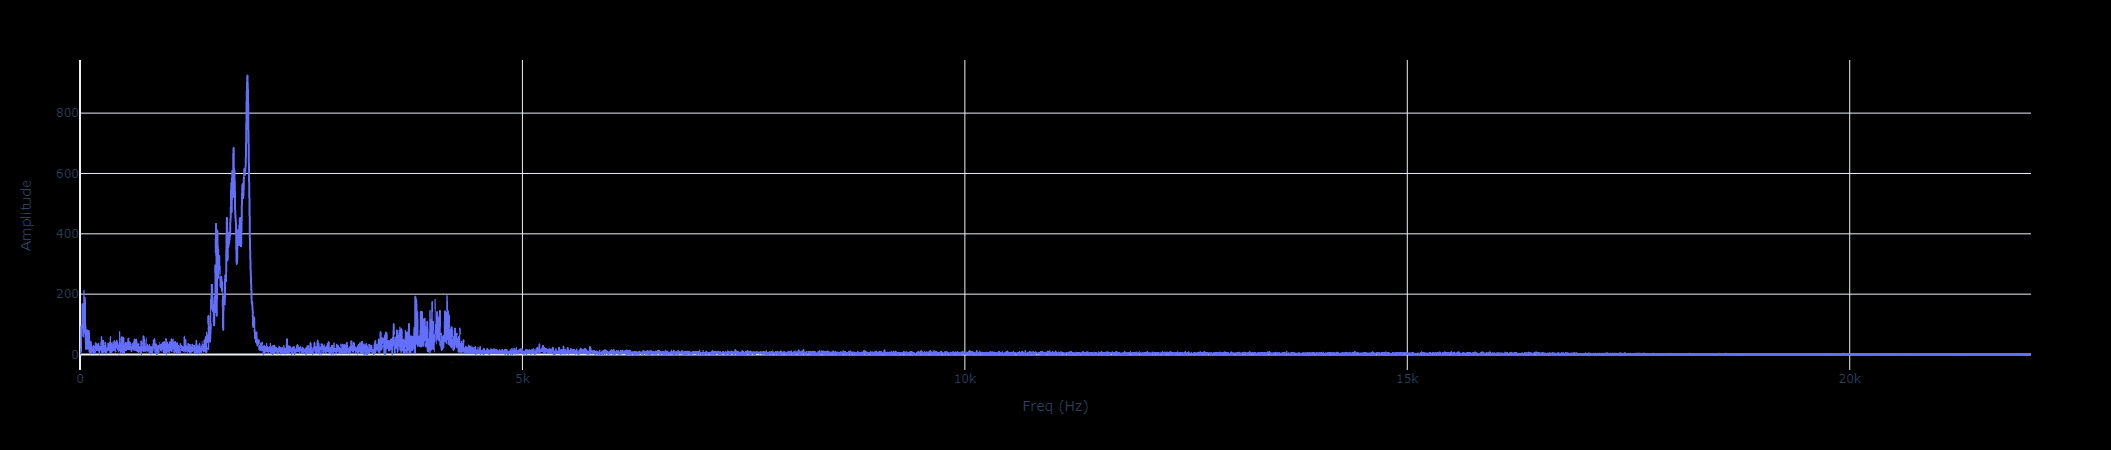

In [11]:
aud_fft_abs = np.abs(aud_fft_c)

# Plot FFT
px.line(
    to_freq_dataframe(aud_fft_abs, fs),
    x='freq', y='amplitude',
    labels = dict(amplitude='Amplitude', freq='Freq (Hz)'),
    template='light_plot'
)

Perfect! Now let's move onto filtering the signal with our hardware FIR...

## Hardware FIR Filter

The LogiCore FIR Compiler gives the user the ability to load and reload filter coefficients, on-the-fly, over AXI4-Stream. In this section we use this functionality to filter our audio data in hardware as well.

### Configuring the FIR

Similar to our FFT, we first have to set up the DMAs associated with the FIRs. There are 3 DMAs here, one for data and two for configuration. 

In [12]:
dma_data = ol.filter.fir_data
dma_config = ol.filter.fir_config
dma_reload = ol.filter.fir_reload

One of the greatest benefits of using PYNQ is that it encourages us to mix our software and hardware in ways rarely implemented before. Remember the coefficients we designed with SciPy's `firwin` function in the previous notebook? We can use those to program the FIR in hardware!

The FIR Compiler is set up to accept 16-bit integers, so we will first need to convert them from their original type of *float*.

In [13]:
hpf_coeffs = np.load('assets/hpf_coeffs.npy')

hpf_coeffs_hw = np.int16(hpf_coeffs/np.max(abs(hpf_coeffs)) * 2**15 - 1)

and because our filter is symmetrical we need only to send half the weights and the FIR compiler will infer the rest...

In [14]:
hpf_coeffs_hw = hpf_coeffs_hw[0:int(len(hpf_coeffs_hw)/2)+1] # 1/2 + 1 weights

Now we can load the new coefficients to the FIR IP over AXI4-Stream using the same DMA transfer routine we used when configuring the FFT, albeit with an extra step. This *reload/config* transfer is explained in more detail in [PG149](https://www.xilinx.com/support/documentation/ip_documentation/fir_compiler/v7_2/pg149-fir-compiler.pdf#page=16).

In [15]:
# Create DMA buffer for coefs
fir_buffer_reload = allocate(shape=(len(hpf_coeffs_hw),),dtype=np.int16)

# Copy coefs to buffer
for i in range(len(hpf_coeffs_hw)):
    fir_buffer_reload[i] = hpf_coeffs_hw[i]

# Transfer coefficients to FIR
dma_reload.sendchannel.transfer(fir_buffer_reload)
dma_reload.sendchannel.wait()

# Send an empty 8-bit packet to FIR config port to complete reload
fir_buffer_config = allocate(shape=(1,),dtype=np.int8)
fir_buffer_config[0] = 0
dma_config.sendchannel.transfer(fir_buffer_config)
dma_config.sendchannel.wait()

# Close the buffers
fir_buffer_reload.close()
fir_buffer_config.close()

### Using the FIR

Now we can try filtering the signal using our weights from SciPy. First we need to convert our `aud_hw` signal back to a 16-bit integer then, similarly to how we transferred data to and from the FFT, can do the same for our filter. 

>You'll notice that, as with the FFT, the output buffer is again a different type from the input. In this case the 32-bit output is to take into account bit growth during the filtering process. 

In [16]:
aud_hw = np.int16(aud_hw)

# Create DMA buffer
fir_in_buffer = allocate(shape=(len(aud_hw),),dtype=np.int16)
fir_out_buffer = allocate(shape=(len(aud_hw),),dtype=np.int32)

# Copy aud_hw to buffer
for i in range(len(aud_hw)):
    fir_in_buffer[i] = aud_hw[i]

# Transfer
dma_data.sendchannel.transfer(fir_in_buffer)
dma_data.recvchannel.transfer(fir_out_buffer)
dma_data.sendchannel.wait()
dma_data.recvchannel.wait()

Then all we need to do is send the result from our FIR to our hardware FFT function, and then plot it!

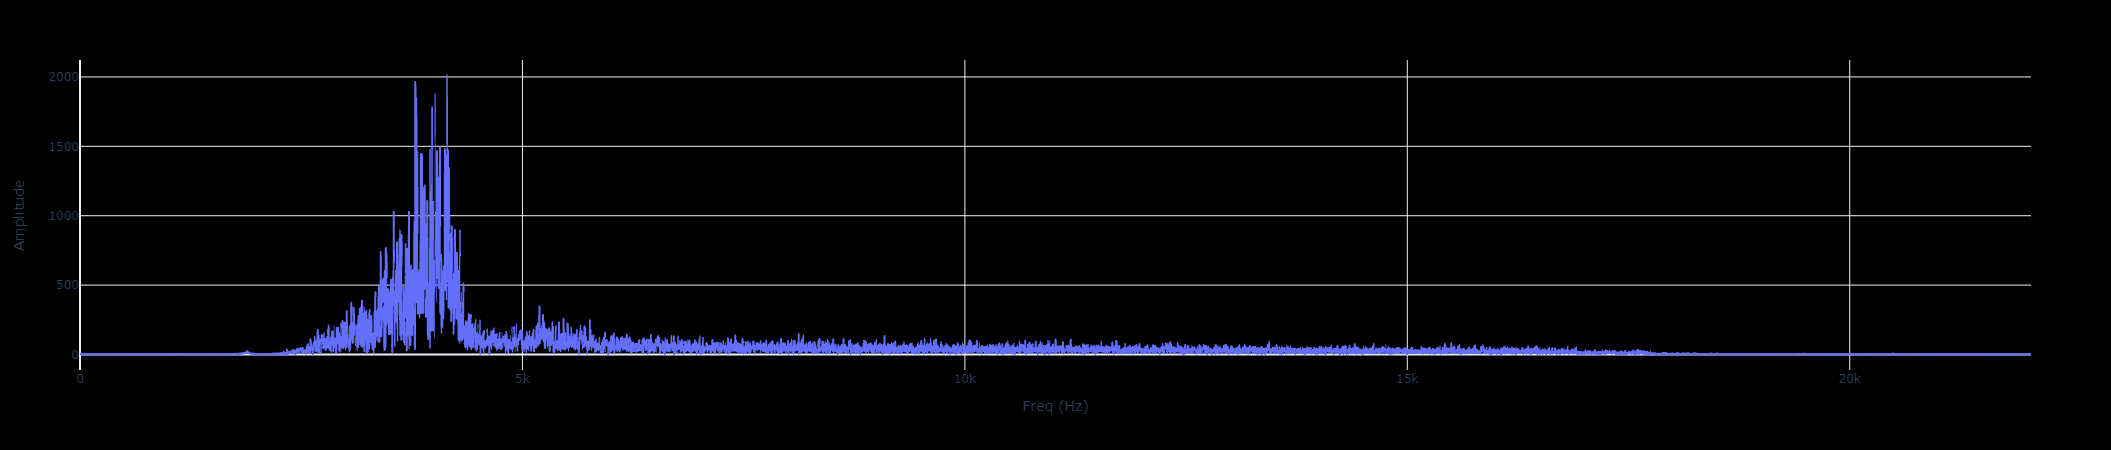

In [17]:
# increase the dynamic range and send to FFT
aud_hpf = np.int16(fir_out_buffer/np.max(abs(fir_out_buffer)) * 2**15 - 1)
# only perform FFT over small subset of data
hpf_fft = fft_hw(aud_hpf[np.int16(fs*0.3):np.int16(fs*0.718)],NFFT)

# make complex number x[n] + j*x[n+1]
hpf_fft_c = np.int16(hpf_fft[0::2])+1j*np.int16(hpf_fft[1::2])

# Plot FFT
px.line(
    to_freq_dataframe(np.abs(hpf_fft_c), fs),
    x='freq', y='amplitude',
    labels = dict(amplitude='Amplitude', freq='Freq (Hz)'),
    template='light_plot'
)

We can see from the new FFT plot that the lower frequencies have been removed by our hardware filter! We can also check the output by converting the signal back to audio.

In [18]:
from IPython.display import Audio

scaled = np.int16(fir_out_buffer/np.max(abs(fir_out_buffer)) * 2**15 - 1)
wavfile.write('assets/hpf_hw.wav', fs, scaled)
Audio('assets/hpf_hw.wav')

Perfect! If you have time, try out the bandpass filter on your own and plot the results.

## Summary 

Let's recap what we've covered in the second notebook:

  * Reusing code between notebooks (including filter coefficients)
  * Getting to know features unique to PYNQ 
      + Viewing the IP dictionary and register maps
      + Transferring data between PS and PL using the DMA class
      + On-the-fly IP reconfiguration
  * Creating Python functions for FPGA hardware